In [ ]:
!pip install opencv-python-headless pytesseract
!apt install tesseract-ocr -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving I.png to I.png


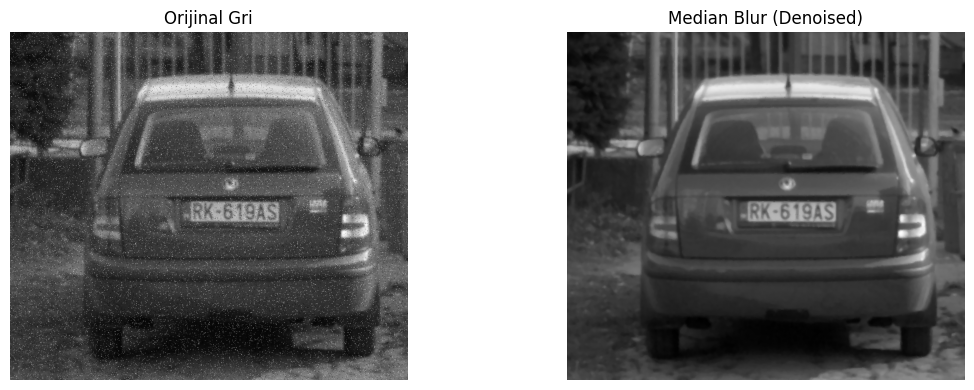

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Yüklenen dosyayı oku
image = cv2.imread('I.png')

# RGB'den Grayscale'e dönüştür
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Median Blur ile tuz-biber gürültüsünü azalt
denoised = cv2.medianBlur(gray, 5)

# Görüntüleri göster
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.title("Orijinal Gri")
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Median Blur (Denoised)")
plt.imshow(denoised, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


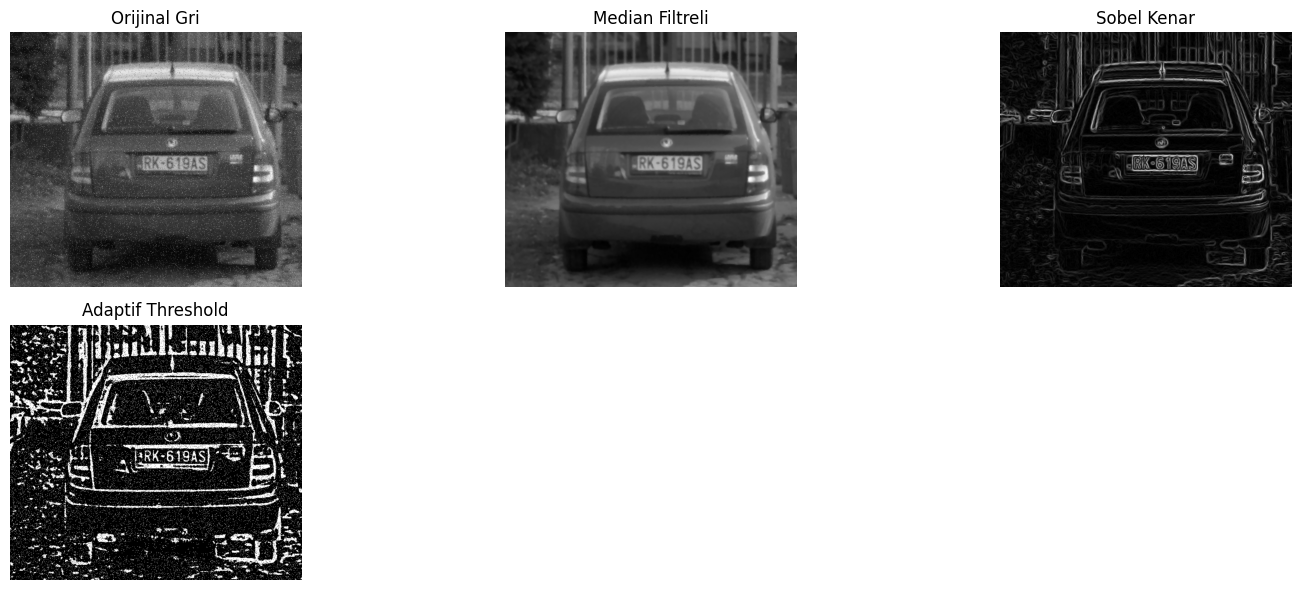

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import threshold_local

# 1. Görüntüyü oku ve griye çevir
image = cv2.imread('I.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Medyan filtre uygula (matlab'daki [5,5] boyutuna eşdeğer)
med_filtered = cv2.medianBlur(gray, 5)

# 3. Sobel ile kenar bulma
sobelx = cv2.Sobel(med_filtered, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(med_filtered, cv2.CV_64F, 0, 1, ksize=3)
sobel_mag = cv2.magnitude(sobelx, sobely)
sobel_mag = np.uint8(sobel_mag)

# 4. Eşikle (adaptif)
T = threshold_local(gray, block_size=35, offset=10)
binary = (gray < T).astype(np.uint8) * 255  # ForegroundPolarity: dark

# 5. Görüntüleri göster
plt.figure(figsize=(15, 6))

plt.subplot(2, 3, 1)
plt.title("Orijinal Gri")
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Median Filtreli")
plt.imshow(med_filtered, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Sobel Kenar")
plt.imshow(sobel_mag, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("Adaptif Threshold")
plt.imshow(binary, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


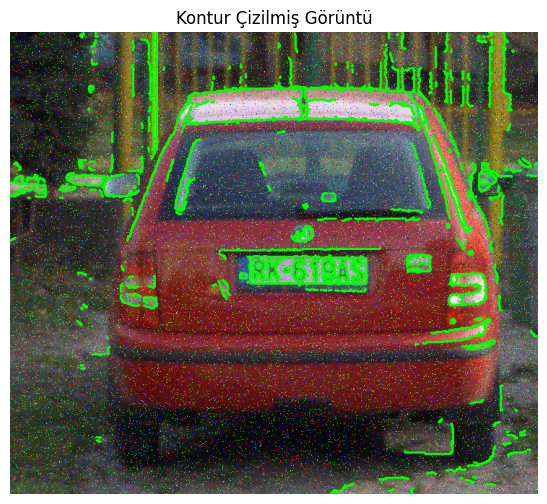

In [ ]:
# 1. Canny ile Kenar Tespiti
edges = cv2.Canny(denoised, 100, 80)

# 2. Kontur Bulma
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 3. Konturları Orijinal Görüntü Üzerine Çizme
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# 4. Görüntüleri Gösterme
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title("Kontur Çizilmiş Görüntü")
plt.axis('off')
plt.show()


array([[[ 25,  29,  23],
        [ 23,  24,  19],
        [ 21,  19,  15],
        ...,
        [ 65,  70,  79],
        [ 65,  69,  79],
        [ 64,  67,  77]],

       [[ 27,  33,  26],
        [ 24,  27,  21],
        [ 21,  21,  15],
        ...,
        [ 63,  68,  77],
        [ 63,  67,  77],
        [ 62,  65,  75]],

       [[ 28,  35,  27],
        [ 25,  29,  21],
        [ 21,  23,  16],
        ...,
        [ 62,   0,  79],
        [ 63,  67,  79],
        [ 61,  65,  77]],

       ...,

       [[ 56,  85,  74],
        [ 55,  86,  74],
        [ 54,  86,  74],
        ...,
        [103, 103, 255],
        [ 97,  98,  99],
        [ 89,  91,  92]],

       [[ 59,  88,  76],
        [ 56, 255,  74],
        [ 53,  85,  72],
        ...,
        [108, 110, 111],
        [104, 106, 107],
        [ 97, 101, 102]],

       [[ 56,  87,  72],
        [ 53,  85,  70],
        [ 50,  83,  67],
        ...,
        [255, 119, 122],
        [113, 119, 121],
        [109, 117, 118]]], dtype=uint8)
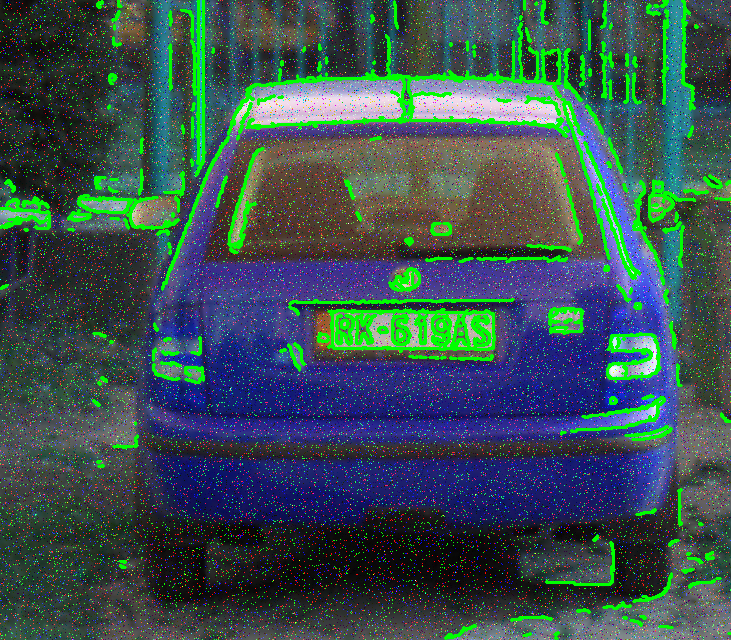

In [ ]:
# Yöntem 1: Sadece median blur sonrası kenar ve kontur işlemleri
edges1 = cv2.Canny(denoised, 100, 80)
contours1, _ = cv2.findContours(edges1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image1 = image.copy()
cv2.drawContours(image1, contours1, -1, (0, 255, 0), 2)


#1 → SRK-6TOAS|


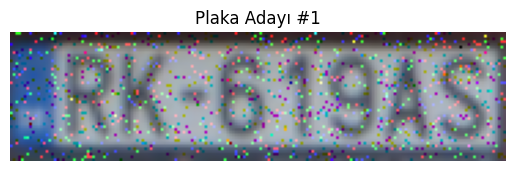

In [ ]:
# Kenarları genişletmek için kernel
kernel = np.ones((5, 5), np.uint8)
dilated_edges = cv2.dilate(edges1, kernel, iterations=1)

# Yeni konturları bul
dilated_contours, _ = cv2.findContours(dilated_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# OCR için tüm uygun dikdörtgenleri dene
plate_texts = []

for cnt in dilated_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h)
    area = cv2.contourArea(cnt)

    # Filtre: plaka gibi dikdörtgen ve yeterli büyüklükte olmalı
    if 2 < aspect_ratio < 8 and 500 < area < 30000:
        roi = image[y:y+h, x:x+w]
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        _, roi_thresh = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # OCR
        config = r'--oem 3 --psm 8'
        text = pytesseract.image_to_string(roi_thresh, config=config).strip()

        if len(text) >= 4:  # 4+ karakterli anlamlı sonuçlar
            plate_texts.append((text, roi))

# Gösterim
if plate_texts:
    for idx, (txt, roi_img) in enumerate(plate_texts):
        print(f"#{idx+1} → {txt}")
        plt.imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Plaka Adayı #{idx+1}")
        plt.axis('off')
        plt.show()
else:
    print("Yine anlamlı plaka adayı bulunamadı 😕")
